# Anime Face Generation

In this notebook, we will train a Deep Convolutional Generative Adversarial Network (DCGAN) to generate new anime faces. This model is based on the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) from Alec Radford, Luke Metz, and Soumith Chintala.

The objective of this project is to use the following Kaggle [dataset](https://www.kaggle.com/datasets/soumikrakshit/anime-faces), in order to generate anime faces using a Deep Convolutional Generative Adversarial Network (DCGAN).

I've used wandb to track the training process. 

In [ ]:
import wandb
wandb.login()

The `folder` variable contains the path to the dataset. 
The `checkpoint` variable contains the path to the checkpoint file.

In [2]:
folder = "./data"
checkpoint = "./checkpoint/0001/"

The dataset contains 21551 images of anime faces. The images are in color and have a resolution of $64 \times 64$ pixels.

In [3]:
import glob

image_urls = glob.glob(folder + "/*.png")
print(len(image_urls))

21551


Set the seed for reproducibility.

In [4]:
import torch
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

These are the imports for the project.

In [5]:
import os
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from pytorch_lightning.core import LightningModule
from pytorch_lightning.trainer import Trainer
import pytorch_lightning as pl
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset
from PIL import Image, ImageOps


The `ImageDataset` class is used to load the images from the dataset. The `__getitem__` method returns the image at the given index. The `__len__` method returns the number of images in the dataset.

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):

        # get the list of all images from the root folder
        self.files = sorted(glob.glob(root))
        self.transform = transform

    def __getitem__(self, index):
        # load the image at the indez
        item = Image.open(self.files[index % len(self.files)])
        if self.transform is None:
          self.transform = transforms.ToTensor()
        tensor = self.transform(item)
        return tensor

    def __len__(self):
        return len(self.files)

The `Generator` class is used to define the generator model. The `forward` method returns the output of the generator model.

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        # started from 8x8 image
        self.init_size = img_shape[1] // 8

        # used a linear layer to map the latent space to a feature map of size 128 x 8 x 8
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            # use the batch normalization to stabilize the training
            nn.BatchNorm2d(128),
            # sample the feature map to double the size
            nn.Upsample(scale_factor=2),
            # convolutional layer to map the feature map to a feature map of size 128 x 16 x 16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), #16x16 -> 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2), #32x32 -> 64x64
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            # final convolutional layer to map the feature map to a feature map of size 3 x 64 x 64
            nn.Conv2d(32, img_shape[0], 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        out = self.l1(z)
        # the feature map is reshaped to a tensor of size 128 x 8 x 8
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

The `Discriminator` class is used to define the discriminator model. The `forward` method returns the output of the discriminator model.

In [15]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        # define the function to build a discriminator block
        def discriminator_block(in_feat, out_feat, bn=True):
            # this include a convolutional layer, a LeakyReLU activation and a dropout layer
            block = [nn.Conv2d(in_feat, out_feat, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                # if bn is True, a batch normalization layer is added
                block.append(nn.BatchNorm2d(out_feat, 0.8))
            return block

        # build the discriminator model
        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # at the end of the discriminator model, we have a feature map of size 128 x 8 x 8
        ds_size = img_shape[1] // 2 ** 4
        # we use a linear layer to map the feature map to a single value
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # the feature map is flattened to a vector
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

The `tensor_to_image` function is used to convert a tensor to an image.

In [28]:
def tensor_to_image(sample_imgs):
    r = []
    for tensor in sample_imgs:
      tensor = tensor.cpu().detach()
      tensor = tensor*255
      tensor = tensor.transpose(0,2)
      tensor = tensor.transpose(0,1)
      tensor = np.array(tensor, dtype=np.uint8)
      r.append(tensor)
    return r

A Deep Convolutional Generative Adversarial Network (DCGAN) is a generative model that consists of two main components: a **generator network** and a **discriminator network**. The generator network takes in a random noise vector and outputs a synthetic image, while the discriminator network takes in both real and synthetic images and outputs a probability that the input image is real. The two networks are trained in a zero-sum game, where the generator tries to generate synthetic images that are indistinguishable from real images, while the discriminator tries to correctly identify real and synthetic images.

The generator network can be represented mathematically as a function `G(z)` where `z` is a random noise vector and `G` outputs a synthetic image. The discriminator network can be represented as a function `D(x)` where `x` is an input image and `D` outputs a probability that `x` is a real image. The objective of the DCGAN is to find the Nash equilibrium of the following minimax game:
$$
min_G max_D V(D,G) = E_{x\sim p_{data}(x)}[log(D(x))] + E_{z\sim p_z(z)}[log(1 - D(G(z)))]
$$
where $p_{data}(x)$ is the distribution of real images and $p_z(z)$ is the distribution of the random noise vectors. The generator is trained to minimize this objective, while the discriminator is trained to maximize it. By alternating the training of the generator and discriminator, the DCGAN can eventually converge to a solution where the synthetic images generated by the generator are indistinguishable from real images.



The hyperparameters for the project are the following:
- `batch_size`: The batch size for the training process are equal to 64.
- `latent_dim`: The latent dimension for the generator is equal to 100.
- `lr`: The learning rate for the Adam optimizer is equal to 0.0002.
- `beta1`: The first beta for the Adam optimizer is equal to 0.5.
- `beta2`: The second beta for the Adam optimizer is equal to 0.999.
- `num_epochs`: The number of epochs for the training process is equal to 33.

In [29]:
from collections import OrderedDict

NUM_EPOCHS = 33

class DCGAN(LightningModule):

    def __init__(self,
                 latent_dim: int = 100,
                 lr: float = 0.0002,
                 b1: float = 0.5,
                 b2: float = 0.999,
                 batch_size: int = 64, **kwargs):
        super().__init__()
        
        # the hyperparameters are saved as class attributes
        self.save_hyperparameters()

        self.latent_dim = latent_dim
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.batch_size = batch_size

        # dimension of the image
        img_shape = (3, 64, 64)
        
        # build the generator and the discriminator
        self.generator = Generator(latent_dim=self.latent_dim, img_shape=img_shape)
        self.discriminator = Discriminator(img_shape=img_shape)

        # we use a fixed noise vector to visualize the progress of the training
        self.validation_z = torch.randn(50, self.latent_dim)

        # example of input for the model
        self.example_input_array = torch.zeros(2, self.latent_dim)

    def forward(self, z):
        # in forward we simply pass the input to the generator
        return self.generator(z)
    
    def configure_optimizers(self):
        lr = self.lr
        b1 = self.b1
        b2 = self.b2

        # define the two optimizers, one for the generator and one for the discriminator
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        
        # return the two optimizers and the scheduler
        return [opt_g, opt_d], []

    # this method is called two times, one for each optimizer. The optimizer_idx parameter is used to distinguish between the two optimizers
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs = batch

        # sample random noise, these will be used as input for the generator and the discriminator
        z = torch.randn(imgs.shape[0], self.latent_dim)
        
        # we need to put the noise on the same device as the images
        z = z.type_as(imgs)

        # train the generator
        if optimizer_idx == 0:

            # generate images from the noise
            generated_imgs = self(z)

            # take the first 8 images generated by the generator and log them
            sample_imgs = generated_imgs[:8]
            self.logger.log_image(key='generated_images', images=tensor_to_image(sample_imgs))

            # define the labels for the images that we have generated, we want the generator to see them as "real" (label 1)
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # log the real images
            self.logger.log_image(key='real_images', images=tensor_to_image(imgs[:8]))
            
            # loss for the generator to fool the discriminator
            g_loss = F.binary_cross_entropy(self.discriminator(self(z)), valid)

            # log the loss
            self.log('generator/loss', g_loss.item())

            # return the loss to the training loop
            tqdm_dict = {'g_loss': g_loss}
            
            # the progress bar is updated with the loss
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            
            return output

        # train the discriminator
        if optimizer_idx == 1:
            # labels for real images
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # get the predictions from the discriminator
            predicted_real_labels = self.discriminator(imgs)

            # loss for real images
            real_loss = F.binary_cross_entropy(predicted_real_labels, valid)

            # get the prediction for fake images
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            # generate predictions for fake images
            predicted_fake_images = self(z).detach()
            predicted_fake_labels = self.discriminator(predicted_fake_images)
            
            # loss for fake images
            fake_loss = F.binary_cross_entropy(predicted_fake_labels, fake)
            
            # loss like the average of the two losses
            d_loss = (real_loss + fake_loss) / 2

            # log the loss for the discriminator
            self.log('discriminator/loss', d_loss.item())
            
            # accuracy for the discriminator (how many fake images are classified as fake and how many real images are classified as real)
            d_fake_acc = (predicted_fake_labels<=0.5).float().mean()
            d_real_acc = (predicted_real_labels>0.5).float().mean()
            
            # final accuracy
            d_acc = (d_fake_acc + d_real_acc)/2
            
            # log
            self.log('discriminator/fake_acc', d_fake_acc.item())
            self.log('discriminator/real_acc', d_real_acc.item())
            self.log('discriminator/overall_acc', d_acc.item())

            tqdm_dict = {'d_loss': d_loss}
            
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            
            return output

    def train_dataloader(self):
        
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

        dataset = ImageDataset(folder + "/*.png", transform=transform)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def on_train_epoch_end(self):
        # at the end of the epoch, we generate some images from the validation noise
        z = self.validation_z.to(self.device)

        # generate images
        sample_imgs = self(z)
        
        # log the images
        self.logger.log_image(key='validation_images', images=tensor_to_image(sample_imgs))
        
        # save the models
        torch.save(self.generator.state_dict(), checkpoint + f"generator_{self.global_step}.pt")
        torch.save(self.discriminator.state_dict(), checkpoint + f"discriminator_{self.global_step}.pt")

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='GAN_FACES_ANIME', # group runs in "GAN_FACES_ANIME" project
                           log_model='all') # log all new checkpoints during training

mnist_gan = DCGAN()
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=wandb_logger, max_epochs=NUM_EPOCHS)

trainer.fit(mnist_gan)

![discriminator](./assets/001.png)
![generator](./assets/002.png)

## Testing the Generator

I've used a checkpoint file to test the generator, this checkpoint file was generated after 33 epochs of training. It can be find inside the `checkpoint` folder.

In [42]:
afg = Generator(100, (3, 64, 64))
afg.load_state_dict(torch.load("./checkpoint/afg.pt"))
afg.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode=nearest)
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=

The `sample_images` function is used to generate a grid of images from the generator.

In [53]:
def sample_images(n):
    # step 1: generate n latent vectors that follow the normal distribution
    z = torch.randn((n, 100))
    # step 2: generate images from the latent vectors
    images = afg(z)
    images = tensor_to_image(images)
    if n==1:
        return images[0]
    else:
        return images

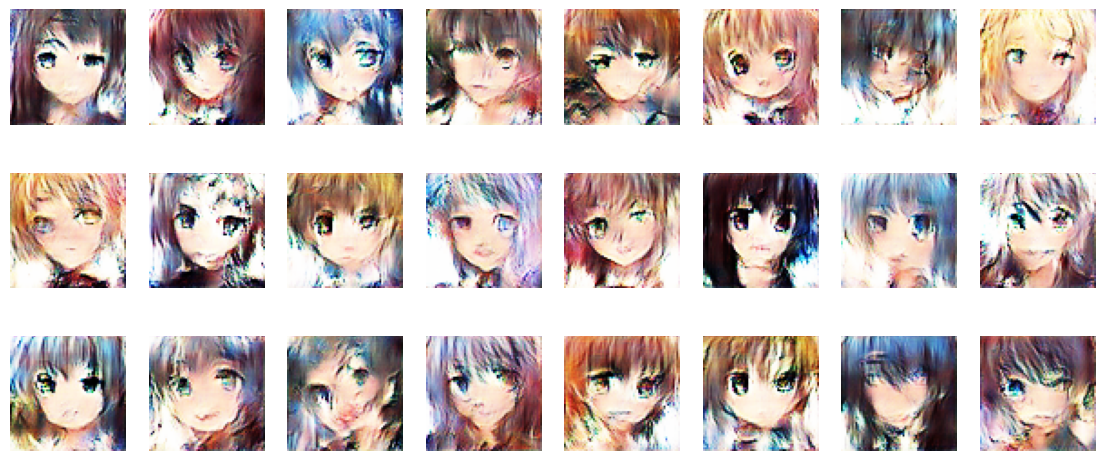

In [54]:
from matplotlib import pyplot as plt

# generate 24 random images
ims = sample_images(24)
i=1

# print the images in a grid
plt.figure(figsize=(14,6))
for im in ims:
    plt.subplot(3,8,i)
    i+=1
    plt.imshow(sample_images(1), cmap='gray')
    plt.axis('off')
plt.show()

Example of interpolated images generated by the generator.

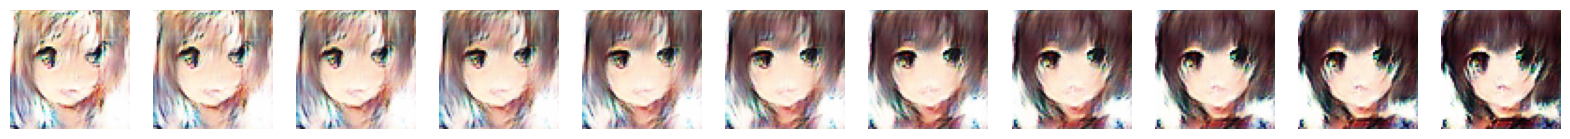

In [61]:
# generate 2 random images
z1 = torch.randn(1,100)
z2 = torch.randn(1,100)

plt.figure(figsize=(20,4))
i = 1

# generate 11 pairs of coefficients (alpha, 1-alpha) that vary from 0 to 1
for alpha in np.arange(0,1.1,0.1):
    # linear interpolation
    z = z1*alpha + (1-alpha)*z2
    
    # generate the image
    im = afg(z)
    im = tensor_to_image(im)[0]
    
    # plot
    plt.subplot(1, 11, i)
    i+=1
    plt.imshow(im, cmap='gray')
    plt.axis('off')